# LayerNorm Exploration

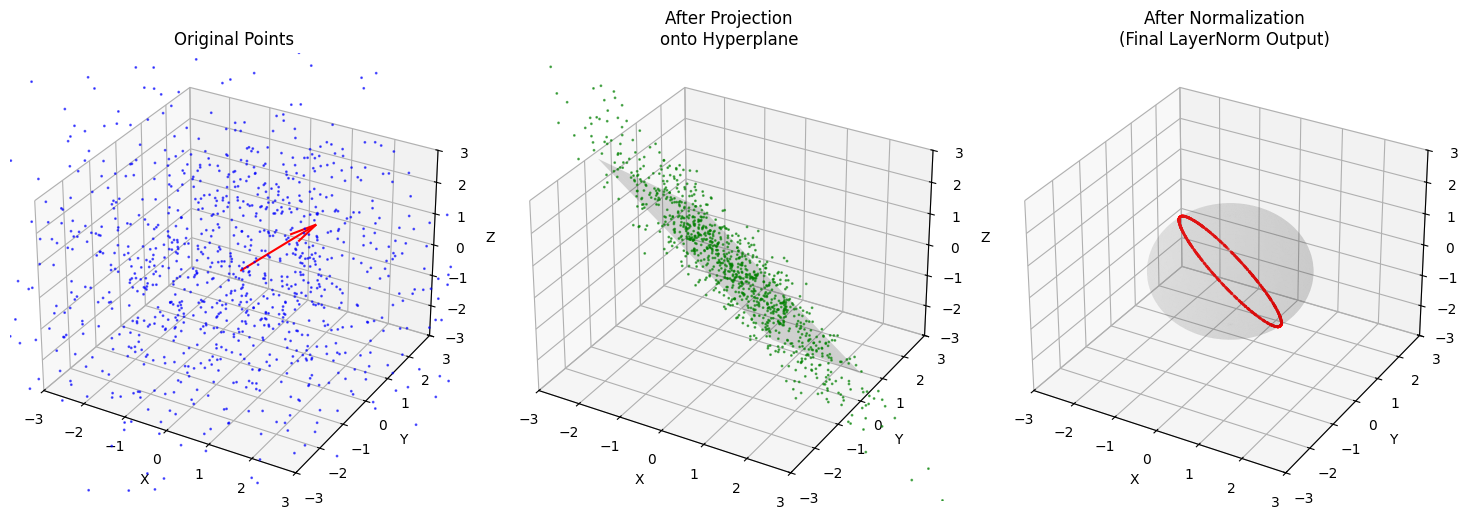

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class LayerNorm(nn.Module):
    eps: float = 1e-5
    
    @nn.compact
    def __call__(self, x):
        # Step 1: Project onto hyperplane (center)
        mean = jnp.mean(x, axis=-1, keepdims=True)
        x_centered = x - mean
        
        # Step 2: Scale to lie within N-ball
        var = jnp.var(x, axis=-1, keepdims=True, ddof=0)
        x_normalized = x_centered / jnp.sqrt(var + self.eps)
        
        return x_normalized, x_centered

def visualize_layernorm_steps():
    # Set random seed for reproducibility
    key = jax.random.PRNGKey(0)
    
    # Generate random 3D points
    n_points = 1000
    points = jax.random.normal(key, (n_points, 3)) * 2

    # Initialize LayerNorm
    layer_norm = LayerNorm()
    variables = layer_norm.init(key, points)
    
    # Pass the points through the LayerNorm module
    points_normalized, points_centered = layer_norm.apply(variables, points)
    
    # Convert to numpy for plotting
    points = np.array(points)
    points_centered = np.array(points_centered)
    points_normalized = np.array(points_normalized)
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Original points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', alpha=0.6, s=1)
    ax1.set_title('Original Points')
    
    # Add unit vector in direction [1,1,1] to show projection axis
    origin = np.zeros(3)
    ones_vector = np.ones(3) / np.sqrt(3)
    ax1.quiver(origin[0], origin[1], origin[2],
               ones_vector[0], ones_vector[1], ones_vector[2],
               color='r', length=2, label='[1,1,1] direction')
    
    # Plot 2: After centering (projection onto hyperplane)
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(points_centered[:, 0], points_centered[:, 1], 
                points_centered[:, 2], c='g', alpha=0.6, s=1)
    ax2.set_title('After Projection\nonto Hyperplane')
    
    # Plot plane perpendicular to [1,1,1]
    xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    a, b, c = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)  # Normal vector components
    d = 0  # Distance from origin
    zz = -(a*xx + b*yy - d)/c
    ax2.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    # Plot 3: After normalization
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(points_normalized[:, 0], points_normalized[:, 1],
                points_normalized[:, 2], c='r', alpha=0.6, s=1)
    ax3.set_title('After Normalization\n(Final LayerNorm Output)')
    
    # Add sphere to show the normalization constraint
    r = np.sqrt(3)  # radius = sqrt(N) as per paper
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax3.plot_surface(x, y, z, color='gray', alpha=0.1)
    
    # Set same scale for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([-3, 3])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

# Create and show the visualization
fig = visualize_layernorm_steps()
plt.show()

Very cool!

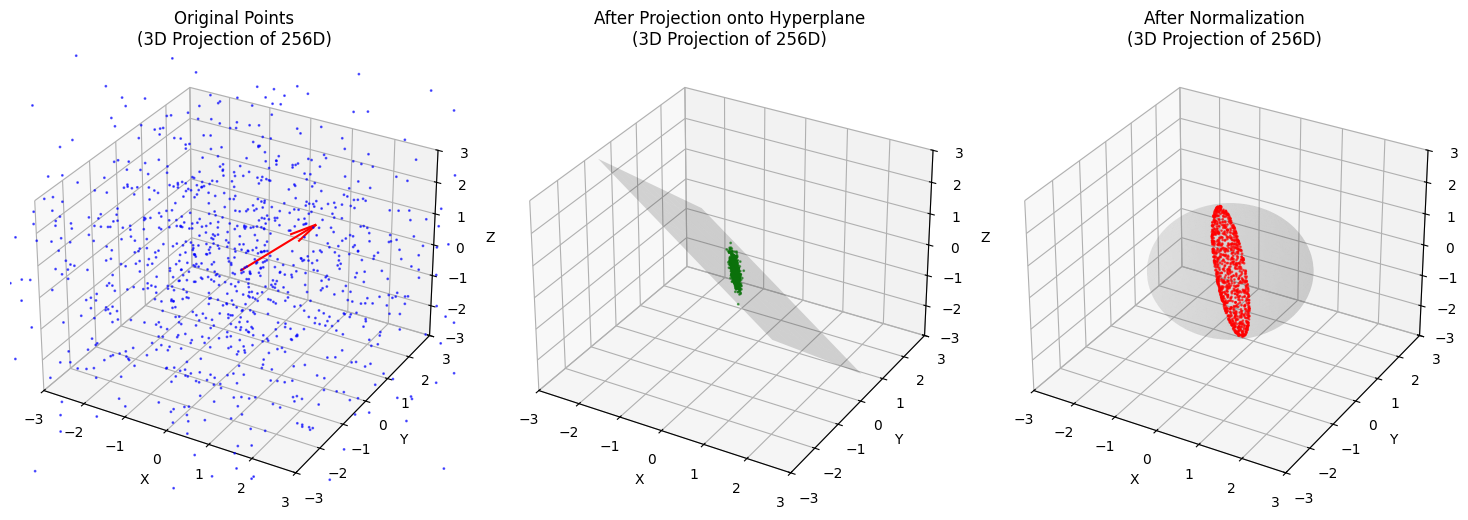

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class LayerNorm(nn.Module):
    eps: float = 1e-5
    
    @nn.compact
    def __call__(self, x):
        mean = jnp.mean(x, axis=-1, keepdims=True)
        x_centered = x - mean
        var = jnp.var(x, axis=-1, keepdims=True, ddof=0)
        x_normalized = x_centered / jnp.sqrt(var + self.eps)
        return x_normalized, x_centered

def project_3d_to_256d(points_3d, key):
    """
    Project 3D points into 256D space while preserving their geometric structure.
    
    Args:
        points_3d: Array of shape (n_points, 3)
        key: JAX random key
    
    Returns:
        Array of shape (n_points, 256)
    """
    n_points = points_3d.shape[0]
    
    # Create an orthonormal basis for the 3D subspace in 256D
    key1, key2 = jax.random.split(key)
    random_matrix = jax.random.normal(key1, (256, 256))
    q, _ = jnp.linalg.qr(random_matrix)  # Get orthonormal basis
    basis = q[:, :3]  # Take first 3 columns as our basis
    
    # Project points into 256D space
    points_256d = points_3d @ basis.T
    
    # Add small random noise in orthogonal directions to make it more realistic
    noise = jax.random.normal(key2, (n_points, 256)) * 0.01
    # Project out the components in our 3D subspace
    for i in range(3):
        noise = noise - jnp.outer(noise @ basis[:, i], basis[:, i])
    
    return points_256d 
def project_256d_to_3d(points_256d, basis):
    """
    Project 256D points back to 3D using the same basis.
    
    Args:
        points_256d: Array of shape (n_points, 256)
        basis: Array of shape (256, 3), the basis used for the original projection
    
    Returns:
        Array of shape (n_points, 3)
    """
    return points_256d @ basis

def visualize_high_dim_layernorm():
    # Set random seed for reproducibility
    key = jax.random.PRNGKey(0)
    
    # Generate random 3D points
    n_points = 1000
    key, subkey = jax.random.split(key)
    points_3d = jax.random.normal(subkey, (n_points, 3)) * 2
    
    # Project to 256D
    key, subkey = jax.random.split(key)
    random_matrix = jax.random.normal(subkey, (256, 256))
    q, _ = jnp.linalg.qr(random_matrix)
    basis = q[:, :3]
    points_256d = project_3d_to_256d(points_3d, key)
    
    # Initialize and apply LayerNorm
    layer_norm = LayerNorm()
    variables = layer_norm.init(key, points_256d)
    points_normalized, points_centered = layer_norm.apply(variables, points_256d)
    
    # Project back to 3D for visualization
    points_3d = np.array(points_3d)
    points_centered_3d = np.array(project_256d_to_3d(points_centered, basis))
    points_normalized_3d = np.array(project_256d_to_3d(points_normalized, basis))
    
    # Create visualization
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Original points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
                c='b', alpha=0.6, s=1)
    ax1.set_title('Original Points\n(3D Projection of 256D)')
    
    # Add unit vector in direction [1,1,1]
    origin = np.zeros(3)
    ones_vector = np.ones(3) / np.sqrt(3)
    ax1.quiver(origin[0], origin[1], origin[2],
               ones_vector[0], ones_vector[1], ones_vector[2],
               color='r', length=2, label='[1,1,1] direction')
    
    # Plot 2: After centering
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(points_centered_3d[:, 0], points_centered_3d[:, 1],
                points_centered_3d[:, 2], c='g', alpha=0.6, s=1)
    ax2.set_title('After Projection onto Hyperplane\n(3D Projection of 256D)')
    
    # Plot plane perpendicular to [1,1,1]
    xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    a, b, c = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)
    d = 0
    zz = -(a*xx + b*yy - d)/c
    ax2.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    # Plot 3: After normalization
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(points_normalized_3d[:, 0], points_normalized_3d[:, 1],
                points_normalized_3d[:, 2], c='r', alpha=0.6, s=1)
    ax3.set_title('After Normalization\n(3D Projection of 256D)')
    
    # Add sphere
    r = np.sqrt(3)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax3.plot_surface(x, y, z, color='gray', alpha=0.1)
    
    # Set same scale for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([-3, 3])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

# Create and show the visualization
fig = visualize_high_dim_layernorm()
plt.show()

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

class LayerNorm(nn.Module):
    eps: float = 1e-5
    
    @nn.compact
    def __call__(self, x):
        mean = jnp.mean(x, axis=-1, keepdims=True)
        x_centered = x - mean
        var = jnp.var(x, axis=-1, keepdims=True, ddof=0)
        x_normalized = x_centered / jnp.sqrt(var + self.eps)
        return x_normalized, x_centered

def project_3d_to_256d(points_3d, key):
    n_points = points_3d.shape[0]
    key1, key2 = jax.random.split(key)
    random_matrix = jax.random.normal(key1, (256, 256))
    q, _ = jnp.linalg.qr(random_matrix)
    basis = q[:, :3]
    points_256d = points_3d @ basis.T
    noise = jax.random.normal(key2, (n_points, 256)) * 0.01
    for i in range(3):
        noise = noise - jnp.outer(noise @ basis[:, i], basis[:, i])
    return points_256d, basis

def project_256d_to_3d(points_256d, basis):
    return points_256d @ basis

def create_plotly_figure(points, title, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=3, color=color, opacity=0.7)
    ))
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        )
    )
    return fig

def visualize_layernorm(n_points=1000):
    key = jax.random.PRNGKey(0)
    key, subkey = jax.random.split(key)
    points_3d = jax.random.normal(subkey, (n_points, 3)) * 2
    points_256d, basis = project_3d_to_256d(points_3d, key)
    layer_norm = LayerNorm()
    variables = layer_norm.init(key, points_256d)
    points_normalized, points_centered = layer_norm.apply(variables, points_256d)
    points_3d = np.array(points_3d)
    points_centered_3d = np.array(project_256d_to_3d(points_centered, basis))
    points_normalized_3d = np.array(project_256d_to_3d(points_normalized, basis))
    
    original_fig = create_plotly_figure(points_3d, 'Original 3D Points', 'blue')
    centered_fig = create_plotly_figure(points_centered_3d, 'Centered Points', 'green')
    normalized_fig = create_plotly_figure(points_normalized_3d, 'Normalized Points', 'red')
    
    return original_fig, centered_fig, normalized_fig

def interactive_visualization(n_points=1000):
    original_fig, centered_fig, normalized_fig = visualize_layernorm(n_points)
    display(original_fig)
    display(centered_fig)
    display(normalized_fig)

widgets.interact(interactive_visualization, n_points=widgets.IntSlider(min=500, max=5000, step=500, value=1000));


Figure({
    'data': [{'marker': {'color': 'blue', 'opacity': 0.7, 'size': 3},
              'mode': 'markers',
              'type': 'scatter3d',
              'x': {'bdata': ('MlGcwIgENb/c+BLAPVWIQHOKJsB2tW' ... '9WpCm+IT7cPy0WJcBN+ME+ocChvg=='),
                    'dtype': 'f4'},
              'y': {'bdata': ('l0iCwLsQw78dJhg/QR/Cvmaqv7+8Wx' ... 'BCYIS+EfKDwAlDRT8s+MY/M+uNPw=='),
                    'dtype': 'f4'},
              'z': {'bdata': ('MHrSPsnaFsCkvyfAgcn2P6X5Pr/m1Q' ... '/iQvC/hUSWP0KYAsCJloy/SnlAwA=='),
                    'dtype': 'f4'}}],
    'layout': {'scene': {'aspectmode': 'cube',
                         'xaxis': {'title': {'text': 'X'}},
                         'yaxis': {'title': {'text': 'Y'}},
                         'zaxis': {'title': {'text': 'Z'}}},
               'template': '...',
               'title': {'text': 'Original 3D Points'}}
})

Figure({
    'data': [{'marker': {'color': 'green', 'opacity': 0.7, 'size': 3},
              'mode': 'markers',
              'type': 'scatter3d',
              'x': {'bdata': ('AqGbwIZOOb8CDxTA44CIQIFjJsAscm' ... '9UgDm+ioPdP3bQJcDEsrs+GT6vvg=='),
                    'dtype': 'f4'},
              'y': {'bdata': ('dwKCwDzrw79KaxY/TAnBvmiLv79uYh' ... 'A3iIe+sNGDwHkaRD9sWMY/kpOMPw=='),
                    'dtype': 'f4'},
              'z': {'bdata': ('kPqvPtV+E8BAWCTAiKb0P5DhQL/Aig' ... '/5DOq/FkmSP6dQAMASrYe/6DA7wA=='),
                    'dtype': 'f4'}}],
    'layout': {'scene': {'aspectmode': 'cube',
                         'xaxis': {'title': {'text': 'X'}},
                         'yaxis': {'title': {'text': 'Y'}},
                         'zaxis': {'title': {'text': 'Z'}}},
               'template': '...',
               'title': {'text': 'Centered Points'}}
})

Figure({
    'data': [{'marker': {'color': 'red', 'opacity': 0.7, 'size': 3},
              'mode': 'markers',
              'type': 'scatter3d',
              'x': {'bdata': ('AMdDwajNgMCZNyjBUMxoQdwiV8HAAr' ... 'DuX8W/OPS/QI25RMHzx0JASkzcvw=='),
                    'dtype': 'f4'},
              'y': {'bdata': ('h4wjwf8tCMEp5ipADZukv3ip98C7lG' ... 'EHNRDABHVkwQWpaEB01E1BHLiwQA=='),
                    'dtype': 'f4'},
              'z': {'bdata': ('gWBdP/UKTcF+uDrBNp7QQN1jecBQ0V' ... 'AbCHnBaId9QDA8GMG3ywzBiFFrwQ=='),
                    'dtype': 'f4'}}],
    'layout': {'scene': {'aspectmode': 'cube',
                         'xaxis': {'title': {'text': 'X'}},
                         'yaxis': {'title': {'text': 'Y'}},
                         'zaxis': {'title': {'text': 'Z'}}},
               'template': '...',
               'title': {'text': 'Normalized Points'}}
})

interactive(children=(IntSlider(value=1000, description='n_points', max=5000, min=500, step=500), Output()), _…